# Fishyscapes Anomaly Detection Benchmark

Fishyscapes is a benchmark for anomaly detection in semantic segmentation. The benchmark is available as part of the **Bayesian Deep Learning Benchmarks** (BDL Benchmarks or `bdlb` for short). BDL Benchmarks is an open-source framework that aims to bridge the gap between the design of deep probabilistic machine learning models and their application to real-world problems, hosted on [GitHub](https://github.com/OATML/bdl-benchmarks).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/hermannsblum/bdl-benchmark/blob/master/notebooks/fishyscapes.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/hermannsblum/bdl-benchmark/blob/master/notebooks/fishyscapes.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [17]:
#@title Dependencies & Prerequisites
#!pip3 install tensorflow-gpu -i https://pypi.tuna.tsinghua.edu.cn/simple
#!pip3 install --upgrade git+https://github.com/hermannsblum/bdl-benchmark.git -i https://pypi.tuna.tsinghua.edu.cn/simple

In [18]:
import os
os.environ["CUDA_DEVICES_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [19]:
#@title Imports and Setup
import bdlb
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  fig, axs = plt.subplots(num_samples, 2, figsize=(7, 2*num_samples))
  for i, blob in enumerate(tfdataset.take(num_samples)):
    image = blob['image_left'].numpy()
    mask = blob['mask'].numpy()
    axs[i][0].imshow(image.astype('int'))
    axs[i][0].axis("off")
    axs[i][0].set(title="Image")
    # map 255 to 2 such that difference between labels is better visible
    mask[mask == 255] = 2
    axs[i][1].imshow(mask[..., 0])
    axs[i][1].axis("off")
    axs[i][1].set(title="Mask")
  fig.show()

In [20]:
fs = bdlb.load(benchmark="fishyscapes", download_and_prepare=False)
fs.download_and_prepare('LostAndFound')

## Accessing and Visualizing the Dataset

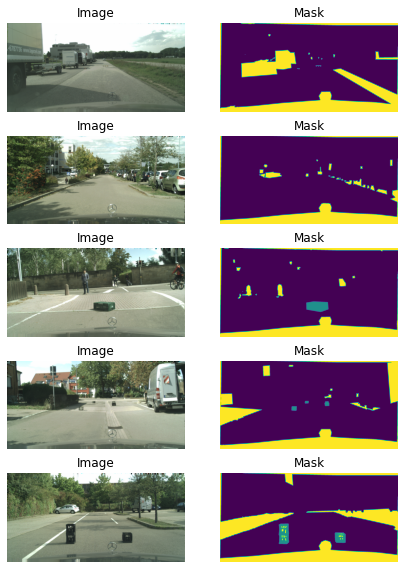

In [21]:
# load the dataset, there is only a validation dataset
ds = tfds.load('fishyscapes/LostAndFound', split='validation')
visualize_tfdataset(ds, 5)

In [22]:
import argparse
args = argparse.Namespace()
args.pretrained = ''
args.arch = 'drn_d_105'
args.classes = 19
args.crop_size = 512
args.resume = '/home/tb5zhh/Cerberus/model_best.pth.tar'
args.phase = 'val'

In [23]:
os.chdir('/home/tb5zhh/Cerberus')
from segment_pspnet import PSPNetBenchmark


cls = PSPNetBenchmark(args)
estimator = lambda im: cls.method(im)



INFO:segment_pspnet:=> loading checkpoint '/home/tb5zhh/Cerberus/model_best.pth.tar'
INFO:segment_pspnet:=> loaded checkpoint '/home/tb5zhh/Cerberus/model_best.pth.tar' (epoch 25)


There are 3 different labels in the Fishyscapes Lost & Found dataset:  
- anomaly (any anomalous object)
- in-distribution (any object or background class that fits into one of the definitions of the [cityscapes classes](https://www.cityscapes-dataset.com/dataset-overview/#labeling-policy))
- void (does not exactly fit to cityscapes classes, but could still be found in cityscapes training images, most often labelled also as void there).

The images were labelled to strictly satisfy the definitions of the first two classes. Applying a coarse labelling that means that some pixels that are labelled void can also belong to the first two classes. In evaluation, we ignore all pixels that are labelled as void.

## Evaluate your Method

  0%|          | 0/2 [00:00<?, ?it/s]

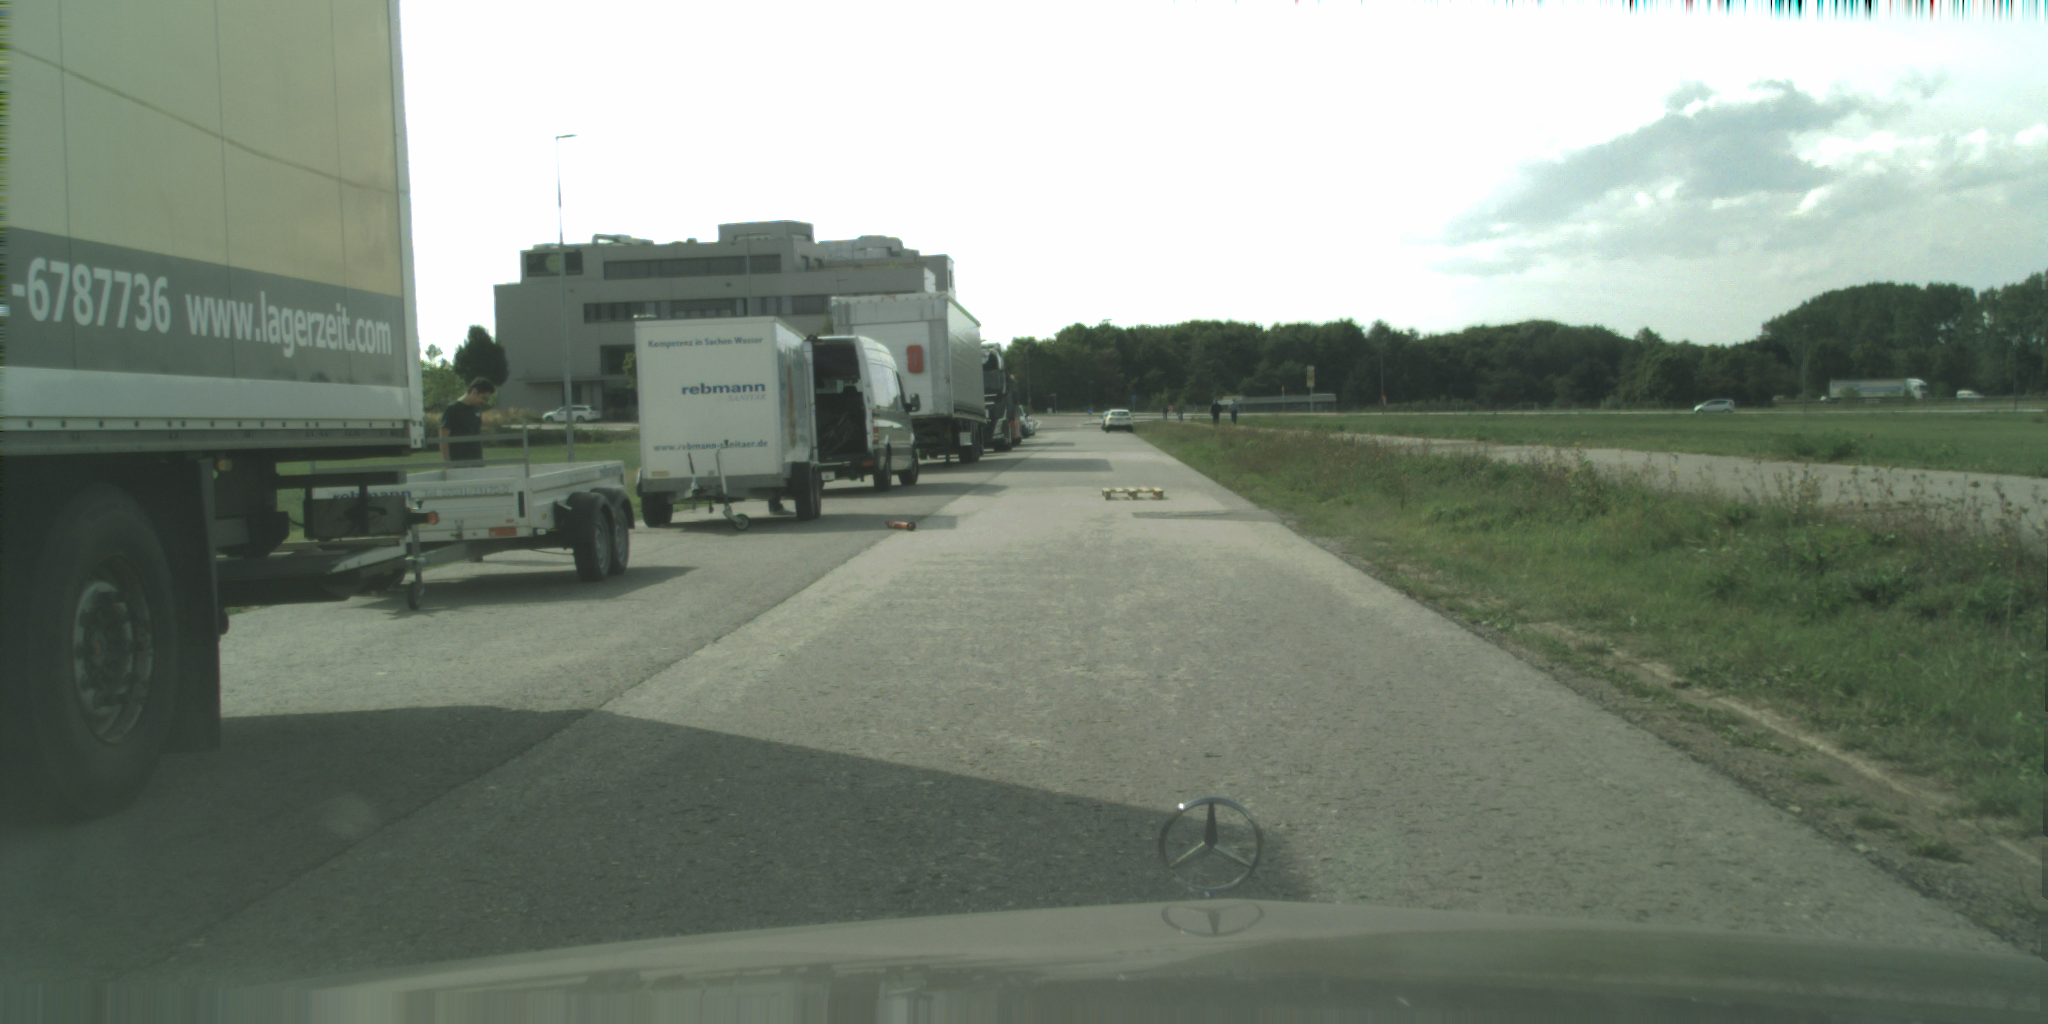

/home/tb5zhh/.conda/envs/cerberus/lib/python3.8/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/tb5zhh/Cerberus/segment_pspnet.py:242: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x), x


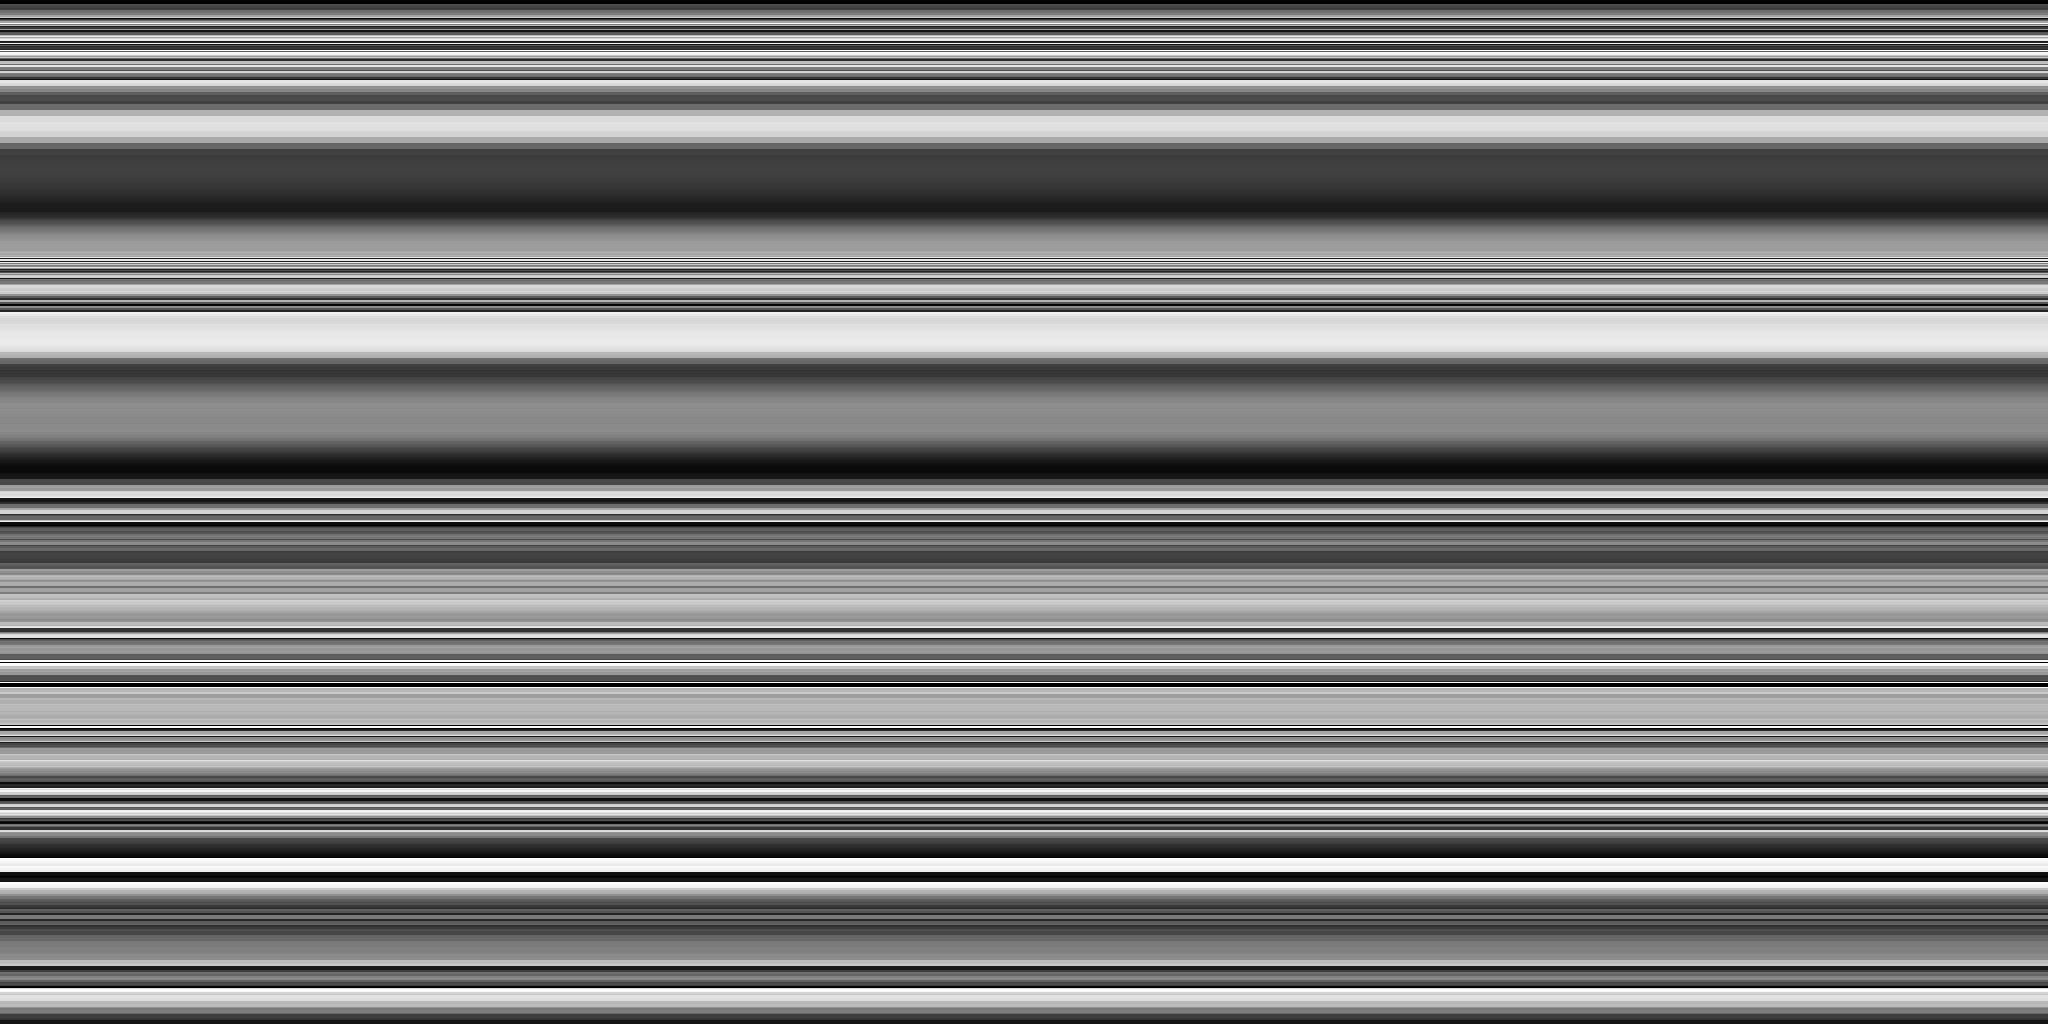

 50%|█████     | 1/2 [00:51<00:51, 51.37s/it]

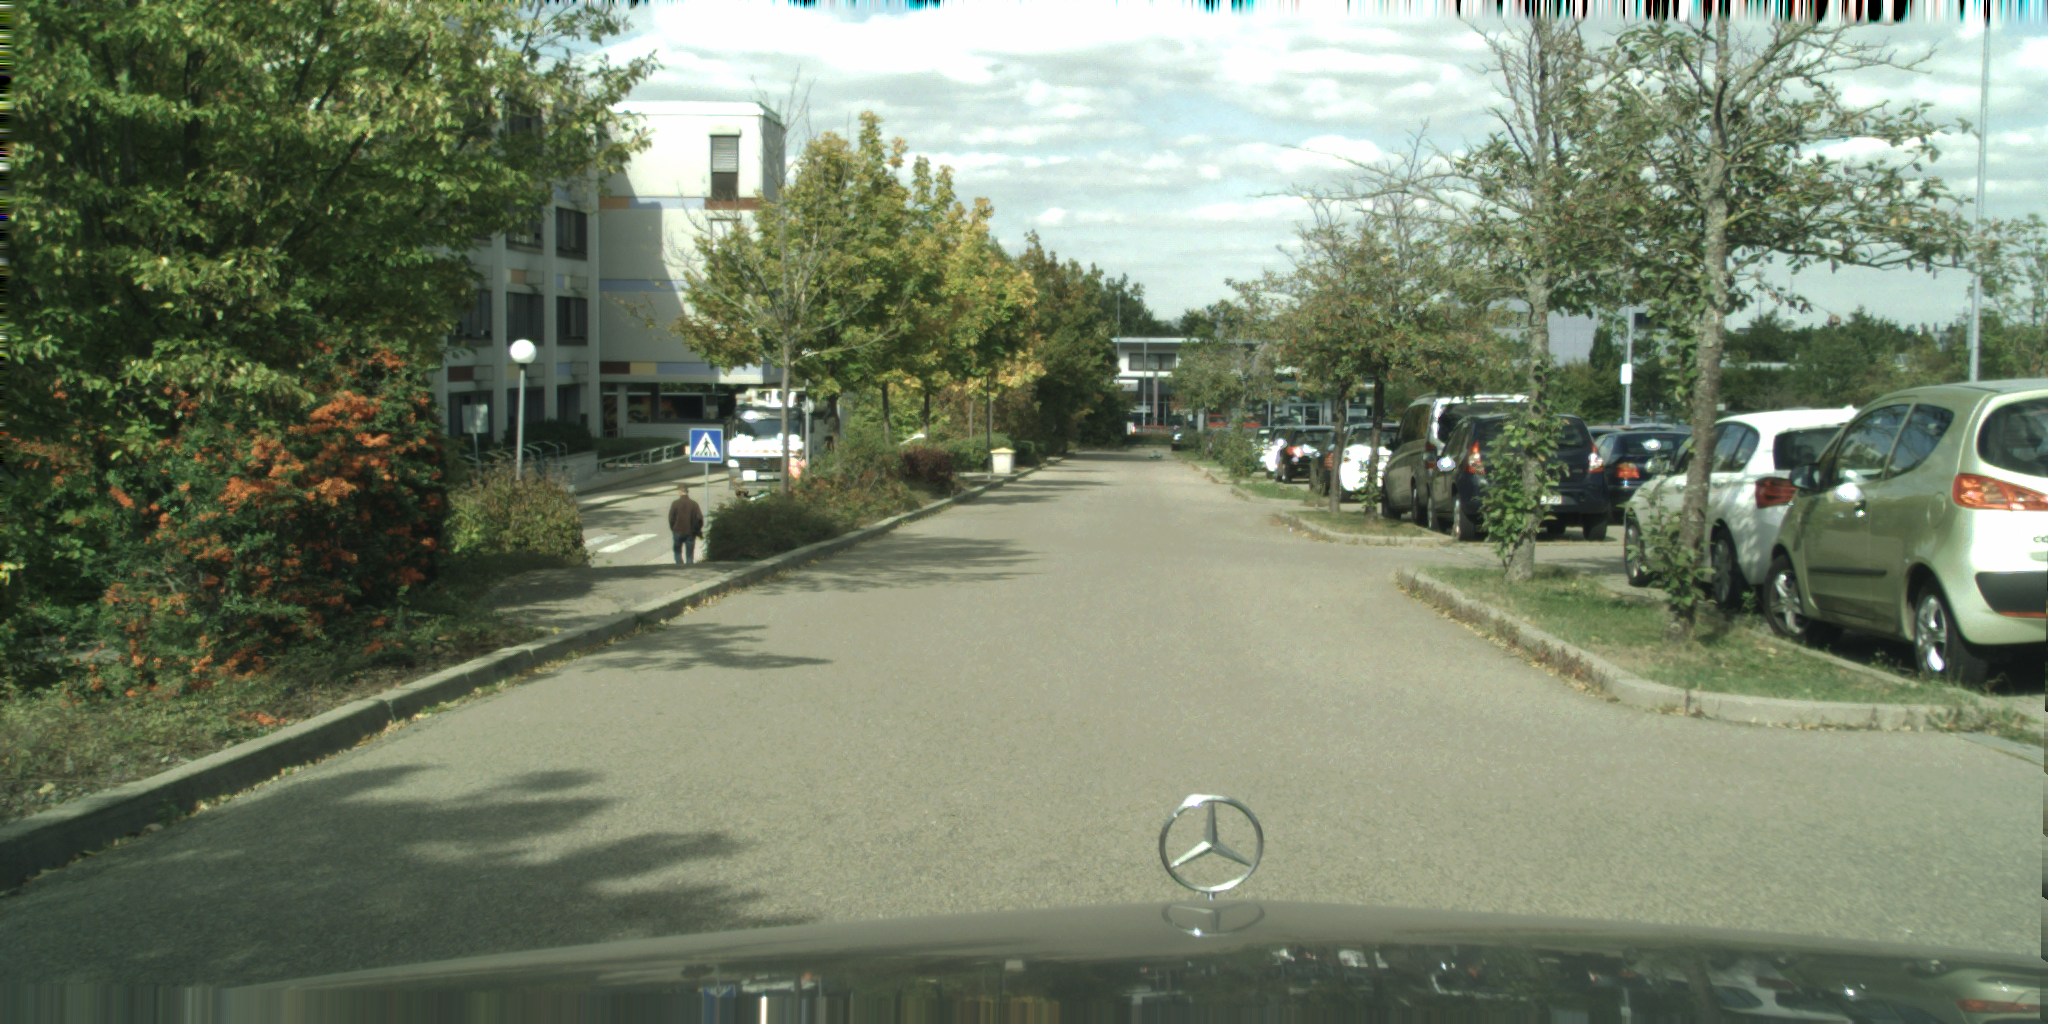

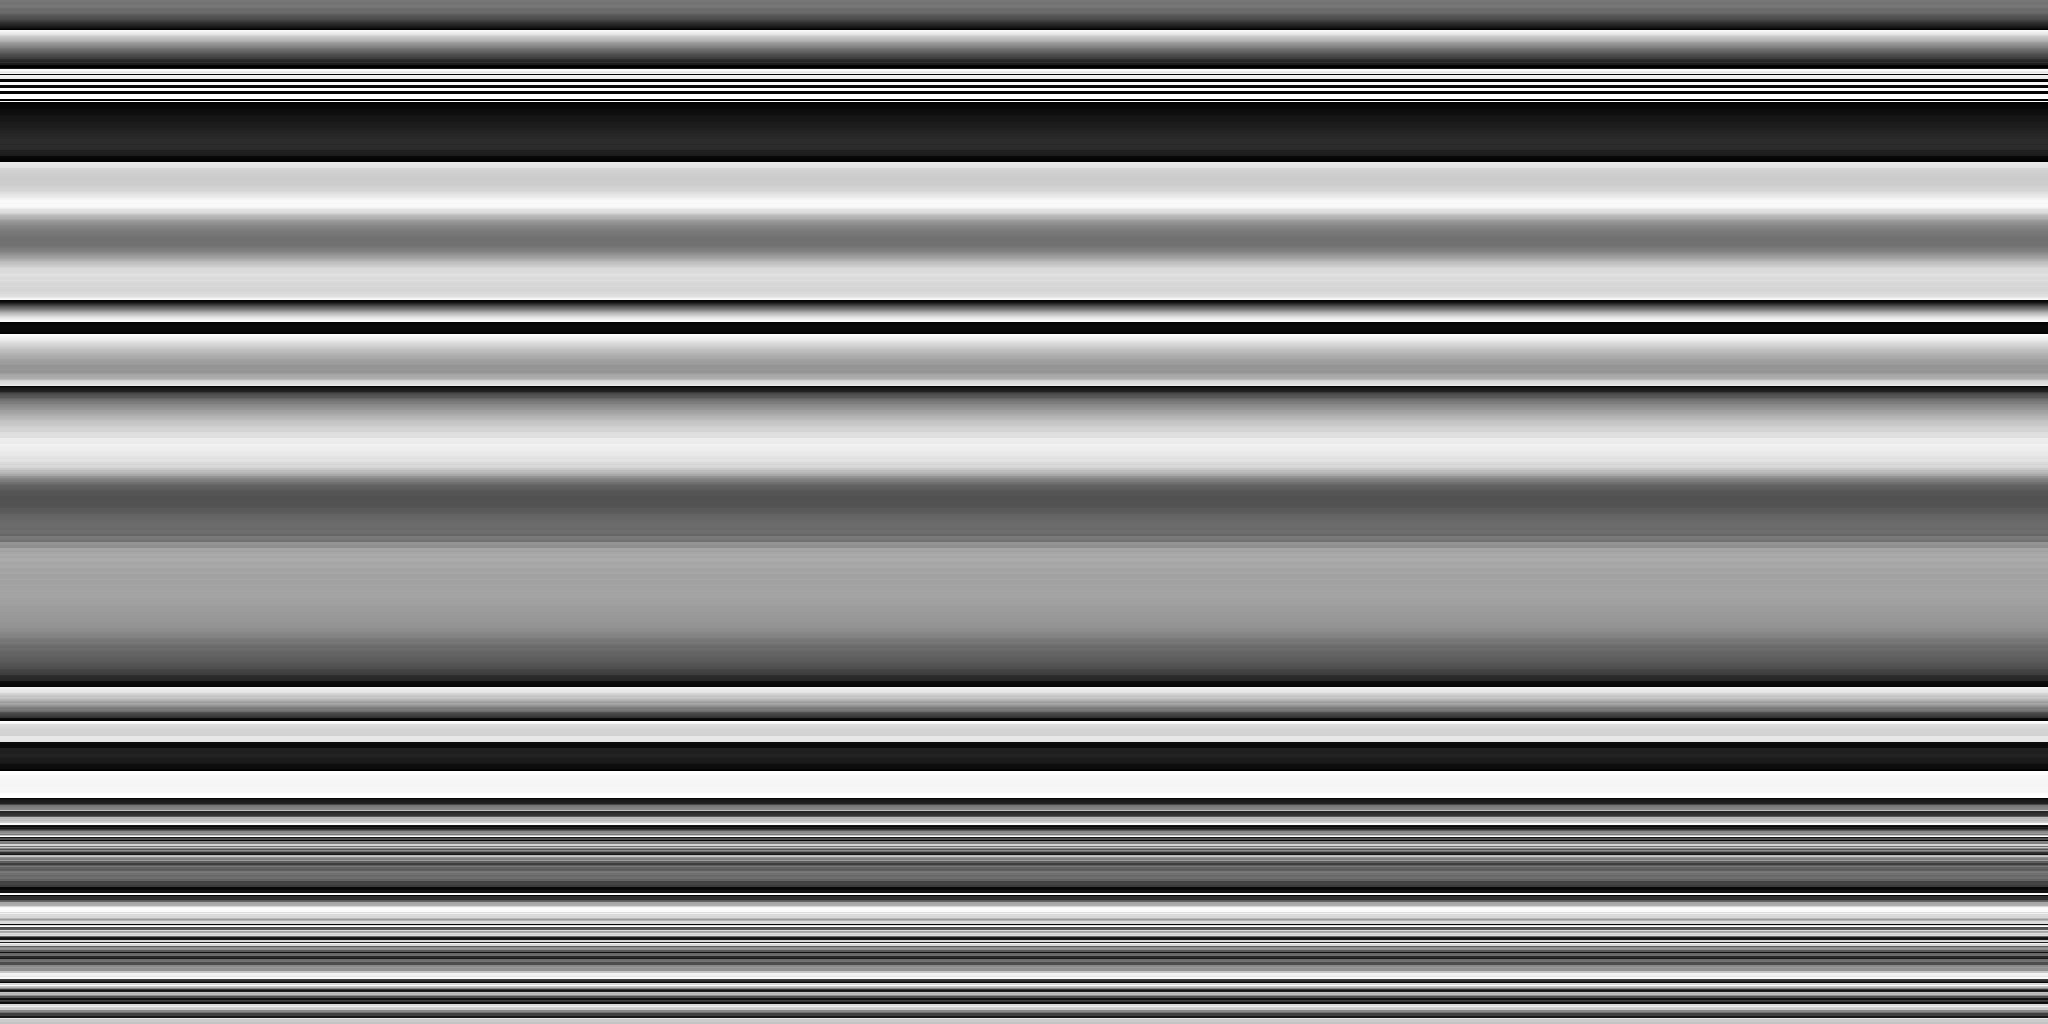

100%|██████████| 2/2 [01:38<00:00, 49.38s/it]


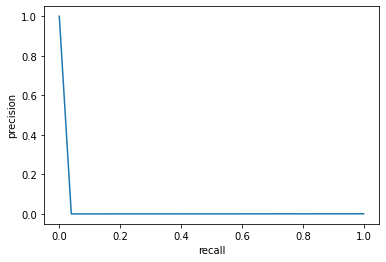

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
%matplotlib inline

# def estimator(image):
#     """Assigns a random uncertainty per pixel."""
#     return uncertainty

def estimator(image):
    display(Image.fromarray(np.asarray(image)))
    input_im = torch.as_tensor(np.asarray(image)).permute(1,0,2).cuda()
    uncertainty = cls.method(input_im)
    uncertainty = torch.sum(uncertainty, dim=0) / uncertainty.shape[0]
    # uncertainty = torch.as_tensor(np.asarray(tf.random.uniform(image.shape[:-1])))
    display(Image.fromarray(np.asarray(torch.stack([uncertainty for _ in range(3)], dim=2) * 255, dtype=np.uint8)))
    return uncertainty

fs = bdlb.load(benchmark="fishyscapes", download_and_prepare=False)
metrics = fs.evaluate(estimator, ds.take(2))

plt.plot(metrics['recall'], metrics['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()